### Notebook Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('ggplot2')
require('readr')
require('extrafont')
require('dplyr')
require('reshape2')
# require('theme538')

R[write to console]: Loading required package: ggplot2



R[write to console]: Loading required package: readr

R[write to console]: Loading required package: extrafont

R[write to console]: Registering fonts with R

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: reshape2



In [4]:
# set maximum number of columns to display
pd.set_option('display.max_columns', None)

# Refrigerator Exploration

In [5]:
epa_ref = pd.read_csv('epa_residential_refrigerators.csv', dtype={'ENERGY STAR Unique ID': str})
epa_freeze =  pd.read_csv('epa_residential_freezers.csv', dtype={'ENERGY STAR Unique ID': str})
doe_ref = pd.read_csv('doe-refrigerator.csv')

In [6]:
print(f"There are {epa_ref.shape} items in epa_ref. Here are the columns:")
display(epa_ref.head(1))
print(f"There are {epa_freeze.shape} items in epa_freeze. Here are the columns:")
display(epa_freeze.head(1))
print(f"There are {doe_ref.shape} items in doe_ref. Here are the columns:") # way more as expected (because DoE should theoretically be a superset of EPA)
display(doe_ref.head(1))

There are (3444, 32) items in epa_ref. Here are the columns:


,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria
0,2369304,Arctic Wind,2ATMW212E,NaN,NaN,Top Freezer,3 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,67.0,33.0,21.0,25.6,396,440.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,10/30/2020,11/09/2020,"United States, Canada",ES_1121980_2ATMW212E_11102020012636_1596636,Yes


There are (402, 25) items in epa_freeze. Here are the columns:


,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria
0,2307583,Danby Premiere,DUFM085A3*,",DUFM085A3WP,",67638013994,Upright Freezer,8 - Upright freezers with manual defrost,Manual,No,No,No,No,8.5,15.0,247,277,11,NaN,NaN,No,12/12/2017,11/30/2017,"United States, Canada",ES_0031682_DUFM085A3*_12012017104803_70163948,No


There are (9326, 10) items in doe_ref. Here are the columns:


,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s
0,Arctic King,(13A.) Compact all-refrigerators - automatic d...,HS-60LN(SNZ),ARM17A5ABB,1.7,246.0,1.7,No,No,https://wx1.sinaimg.cn/mw2000/7db66851ly1h1861...


In [7]:
# columns in epa_ref that aren't in epa_freeze
print(f"Columns in epa_ref that aren't in epa_freeze:")
set(epa_ref.columns) - set(epa_freeze.columns)

Columns in epa_ref that aren't in epa_freeze:


{'Communication Standard Application Layer',
 'Connected Functionality Tested',
 'Connects Using',
 'Counter Depth',
 'Direct on-premises Open-standard Based Interconnection',
 'Height (in)',
 'Width (in)'}

### Exploring the product codes

In [8]:
# !pip install natsort


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [9]:
from natsort import natsort_keygen, natsorted
# natural sort (to sort values like 1A, 3B etc...)
# https://stackoverflow.com/questions/29580978/naturally-sorting-pandas-dataframe

In [10]:
# How many items for each EPA code? 

epa_all = pd.concat([epa_ref, epa_freeze])
epa_codes = epa_all.pivot_table(index='Product Class', values='ENERGY STAR Unique ID', aggfunc='count', fill_value=0)
epa_codes = epa_codes.reset_index().rename(columns={'ENERGY STAR Unique ID': 'count'})
epa_codes_split = epa_codes['Product Class'].str.split(' -', n=1, expand=True).rename(columns={0: 'code', 1: 'description'})
epa_codes = pd.concat([epa_codes_split, epa_codes], axis=1)
epa_codes = epa_codes[['code', 'description', 'count']]
epa_codes.set_index('code', inplace=True)
epa_codes['percent'] = epa_codes['count'] / epa_codes['count'].sum() * 100
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    # display table with title
    display(epa_codes.sort_values('code', key=natsort_keygen()).style.set_caption("EPA Product Class Codes"))


,description,count,percent
code,,,
1,Built-in Compact Cooler,6,0.156006
1,Refrigerator-Freezer and Refrigerator other than All-Refrigerator - manual defrost,3,0.078003
1A,All-Refrigerators - manual defrost,4,0.104004
2,Refrigerator-Freezer - partial automatic defrost,1,0.026001
2,Built-in Cooler,10,0.260010
3,Refrigerator-freezers - automatic defrost with top-mounted freezer without an automatic ice maker,432,11.232449
3,Freestanding Compact Cooler,43,1.118045
3A,All-Refrigerators - automatic defrost,39,1.014041
3A-BI,Built-In All-Refrigerators - automatic defrost,103,2.678107


In [11]:
# Extract codes from doe into their own column
doe_ref['code'] =  doe_ref['Product_Group_Code_Description_s'].str.extract(r'\((.*)\.\)')

# get unique codes and view them
doe_codes = doe_ref.pivot_table(index='Product_Group_Code_Description_s', values ='Brand_Name_s__s', aggfunc='count', fill_value=0).reset_index()
doe_codes.columns = ['Product_Group_Code_Description_s', 'count']

doe_codes['code'] = doe_codes['Product_Group_Code_Description_s'].str.extract(r'\((.*)\.\)')
doe_codes['description'] = doe_codes['Product_Group_Code_Description_s'].str.extract(r'\(.*\) (.*)')
doe_codes.drop(columns=['Product_Group_Code_Description_s'], inplace=True)
doe_codes = doe_codes[['code', 'description', 'count']]
doe_codes['percent'] = doe_codes['count'] / doe_codes['count'].sum() * 100
doe_codes.set_index('code', inplace=True)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    # display table with title
    display(doe_codes.sort_values('code', key=natsort_keygen()).style.set_caption("DOE Product Class Codes"))


,description,count,percent
code,,,
nan,Refrigerator-freezers and refrigerators other than all-refrigerators with manual defrost,84,0.900708
1A,All-refrigerators - manual defrost,13,0.139395
2,Refrigerator-freezers - partial automatic defrost,33,0.353849
3,Refrigerator-freezers - automatic defrost with top-mounted freezer without an automatic icemaker,1183,12.684967
3-BI,Built-in refrigerator-freezer - automatic defrost with top-mounted freezer without an automatic icemaker,3,0.032168
3A,All-refrigerators - automatic defrost,67,0.718422
3A-BI,Built-in All-refrigerators - automatic defrost,149,1.597684
3I,Refrigerator-freezers - automatic defrost with top-mounted freezer with an automatic icemaker without through-the-door ice service,930,9.972121
3I-BI,Built-in refrigerator-freezers - automatic defrost with top-mounted freezer with an automatic icemaker without through-the-door ice service,4,0.042891


In [47]:
# How many items in epa_all that has "compact" in their description?
print(f"There are {len(epa_all[epa_all['Product Class'].str.contains('Compact')])} compact items in epa_all.")

# How many items in doe that has "compact" in their description?
print(f"There are {len(doe_ref[doe_ref['Product_Group_Code_Description_s'].str.contains('Compact')])} compact items in doe_ref.")

There are 1675 compact items in epa_all.
There are 2686 compact items in doe_ref.


So the product codes are comparable for the most part, but messy. EPA sometimes has the same product code twice with different descriptions. If we want to compare across codes, we may have to do some cleanup. Additionally, the codes seem like a combo of categories like "compact" or "upright". We may want to turn these into binary variables if that distinction matters. It seems like there are more compact fridges in the EPA dataset. We'll see if that is still the case after we separate out the duplicates, but that's just something to keep in mind before we take a mean. Do we need to treat different subsets of the data differntly? Are compact fridges inherently more efficient than other types of fridges? If so, having more compact fridges might skew the mean.

### Overview

Questions: 
- lot more epa refrigerators than freezers (I'll want to check both for duplicates prior to joining)
- lot more doe than epa (this is expected as doe *should*  be a superset of epa - i'll want to check that this is the case and if not what are the diffs and can we explain them)


In [12]:
display(epa_ref.describe().round(1))
display(epa_freeze.describe().round(1))
display(doe_ref.describe().round(1))

,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard
count,3444.0,3444.0,3444.0,3444.0,3444.0,3436.0,3436.0
mean,53.0,25.9,12.0,14.2,376.9,427.6,13.0
std,20.2,7.4,8.5,10.7,163.5,172.1,6.7
min,14.0,14.6,1.0,1.0,88.0,168.0,-32.0
25%,33.3,19.0,3.3,3.8,230.0,287.0,10.0
50%,64.8,24.0,10.7,12.6,327.0,371.0,11.0
75%,69.8,31.1,19.4,23.0,498.2,563.2,13.0
max,84.5,65.6,31.6,39.9,807.0,885.0,61.0


,Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard
count,402.0,402.0,402.0,402.0,402.0
mean,11.1,19.5,369.3,422.1,12.7
std,6.1,10.6,114.4,132.1,4.6
min,1.1,1.9,137.0,178.0,8.0
25%,5.8,10.3,241.0,272.0,10.0
50%,11.2,19.8,394.0,438.0,11.0
75%,15.8,27.8,452.0,530.0,13.0
max,21.7,38.1,649.0,717.0,37.0


,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d
count,9326.0,9326.0,9326.0
mean,18.6,443.3,14.8
std,10.3,165.6,7.9
min,1.5,110.0,1.1
25%,8.3,297.0,5.6
50%,22.0,436.0,17.7
75%,25.9,579.0,20.5
max,44.0,885.0,31.5


## What are the differencees between EPA and DOE data?


<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

Text(0.5, 1.0, 'Refrigerator Volume (ft3) in each dataset')

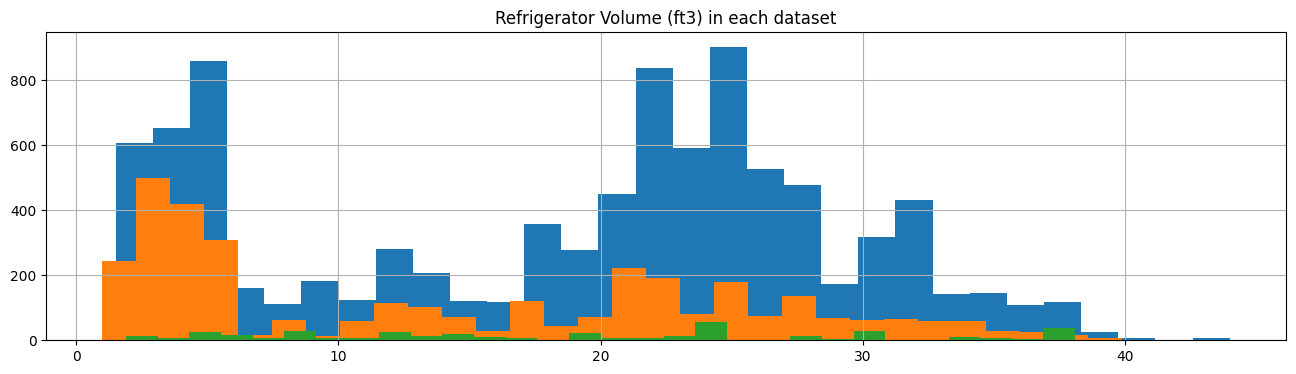

In [13]:
# plot histograms of cubic feet 
display(doe_ref['Total_Adjusted_Volume__Cubic_Feet__d'].hist(bins=30, figsize=(16, 4))) # blue
display(epa_ref['Adjusted Volume (ft3)'].hist(bins=30, figsize=(16, 4))) # orange
display(epa_freeze['Adjusted Volume (ft3)'].hist(bins=30, figsize=(16, 4))) # green


# add title
plt.title('Refrigerator Volume (ft3) in each dataset')

It seems to me that there are probably two types of fridges, the small ones and the big ones...the distribution of the freezers seems a bit more uniform. 

The two peaks on the DOE data (blue histogram) are about equal height, whereas the right peak is way smaller than the left peak in the EPA data (orange histogram). This could mean that the EPA data has more minifridges, relatively speaking. I'm not totally sure yet, but I'm getting the sense that the types of fridges differ in each dataset (note, at this point these datsets overlap...we will try to separate them in the next step), so taking the mean across all fridges may not be methodologically sound if for instance, by their nature big fridges are just less efficient than small ones and one dataset just contains more of one than another relatively speaking. What about vertical vs horizontal ones (heat rises, does it take more energy to have a freezer on top vs on bottom?). Is it fair to compare fridge/refrigerator combos to just fridges alone. Are toploading (icebox style) fridges comparable to side-loading fridges? Does the EPA take into consideration these distinctions? What (if anything) do we need to control for?

All worth thinking about. 

## Efficiency

Before I do any joining and merging etc, let me just take a quick look at one more column, since we plan to calculate energy efficiency, let's look at that too across these three datasets.


In [14]:
epa_ref['energy_per_volume'] = epa_ref['Annual Energy Use (kWh/yr)'] / epa_ref['Adjusted Volume (ft3)']
epa_freeze['energy_per_volume'] = epa_freeze['Annual Energy Use (kWh/yr)'] / epa_freeze['Adjusted Volume (ft3)']
doe_ref['energy_per_volume'] = doe_ref['Annual_Energy_Use__Kilowatt_Hours_Year__d'] / doe_ref['Total_Adjusted_Volume__Cubic_Feet__d']

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

Text(0.5, 1.0, 'Energy per Volume (kWh/yr/ft3)')

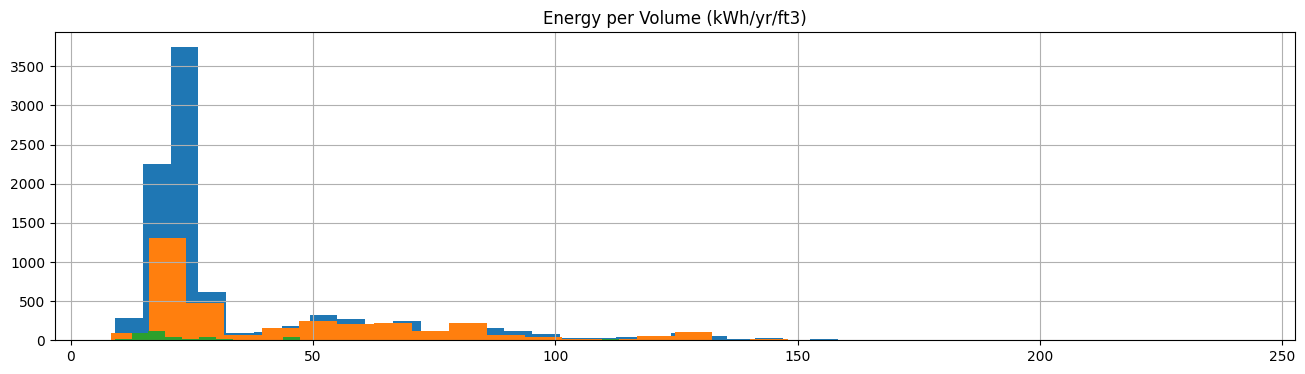

In [15]:
# plot energy_per_volume
display(doe_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # blue
display(epa_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # orange
display(epa_freeze['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # green

# add title
plt.title('Energy per Volume (kWh/yr/ft3)')

So it looks like the DOE dataset has a similar distribution, but with WAY more low energy per volume (high efficiency) datapoints. I wonder why. And what is the relationship between this efficiency measure and the size of the fridge? Again, we'll try this later on after de-duping across the datasets.

# Understanding Duplicates

prior to combining `epa_ref` and `epa_freeze` let's explore them

In [16]:
# There should have mututally exclusive sets of IDs (THERE ARE)
set(epa_ref['ENERGY STAR Unique ID']).intersection(set(epa_freeze['ENERGY STAR Unique ID'])) == set()

True

In [18]:
# There should have mututally exclusive sets of Model Number
model_numbers_in_both = set(epa_ref['Model Number']).intersection(set(epa_freeze['Model Number']))
print(f"There are {len(model_numbers_in_both)} model numbers in both epa_ref and epa_freeze. What's up with that?")
model_numbers_in_both

There are 13 model numbers in both epa_ref and epa_freeze. What's up with that?


{'AU83ETWBR1RCM',
 'BD-305WE-B-A-62H',
 'BD-305WE-B-A1-62H',
 'EUF14CE**',
 'FGVU21F8QF*',
 'HVUF11SL',
 'HVUF11SLF',
 'KMR11MS2EA16C',
 'LRU14F3ASTC',
 'LRU14F3AWWC',
 'RB36S',
 'VF108K0W',
 'VSF11US2A16'}

you can explore those in the cell below

In [19]:
model_number_to_view = 'AU83ETWBR1RCM'
display(epa_ref.query("`Model Number` == @model_number_to_view"))
display(epa_freeze.query("`Model Number` == @model_number_to_view"))

,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume
119,2453235,Arctic King,AU83ETWBR1RCM,NaN,NaN,Compact Refrigerator,13A - Compact All-Refrigerators - automatic de...,Automatic,Yes,No,No,No,No,66.9,24.0,8.3,8.3,167,335.0,50.0,NaN,NaN,No,NaN,NaN,NaN,NaN,04/11/2023,04/11/2023,"United States, Canada",ES_1030337_AU83ETWBR1RCM7_04122023100711_80165973,Yes,20.120482


,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume
61,2363422,Arctic King,AU83ETWBR1RCM,NaN,NaN,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,8.3,14.5,317,353,10,NaN,NaN,No,07/20/2020,07/23/2020,"United States, Canada",ES_1030337_AU83ETWBR1RCM_07242020024616_8776483,No,21.862069
62,2366125,Arctic King,AU83ETWBR1RCM,NaN,NaN,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,8.3,14.6,317,354,10,NaN,NaN,No,09/21/2020,09/11/2020,"United States, Canada",ES_1030337_AU83ETWBR1RCM_09222020021817_5550000_,No,21.712329


In [20]:
epa_ref['source'] = 'epa_ref'
epa_freeze['source'] = 'epa_freeze'
epa_all = pd.concat([epa_ref, epa_freeze])
epa_all.head(1)

,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume,source
0,2369304,Arctic Wind,2ATMW212E,NaN,NaN,Top Freezer,3 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,67.0,33.0,21.0,25.6,396,440.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,10/30/2020,11/09/2020,"United States, Canada",ES_1121980_2ATMW212E_11102020012636_1596636,Yes,15.46875,epa_ref


In [21]:
# Duplicate model numbers
model_no_duplicate = epa_all[epa_all.duplicated(subset=['Model Number'], keep=False)]
print(f"There are {len(model_no_duplicate)} duplicate model numbers in epa_all")

# Duplicate model numbers and brand
brand_name_and_model_no_duplicate = epa_all[epa_all.duplicated(["Brand Name", "Model Number"], keep=False)].sort_values(by=['Brand Name', 'Model Number'])
print(f"There are {len(brand_name_and_model_no_duplicate)} duplicate model numbers and brand name combinations in epa_all")


There are 431 duplicate model numbers in epa_all
There are 373 duplicate model numbers and brand name combinations in epa_all


In [22]:
print("Therefore, sometimes the model number is the same but brand name is different. See below.")
epa_ref[epa_ref['Model Number'] == 'RDBM191**']

Therefore, sometimes the model number is the same but brand name is different. See below.


,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume,source
64,2388871,Alpha PAR RD,RDBM191**,NaN,NaN,Bottom Freezer,5 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,66.4,29.5,18.7,23.0,466,521.0,11.0,NaN,NaN,No,NaN,NaN,NaN,NaN,12/01/2021,11/18/2021,Canada,ES_1125680_RDBM191**_12072021011649_ 80106135,No,20.26087,epa_ref
695,2382972,EuroDesign,RDBM191**,NaN,NaN,Bottom Freezer,5 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,66.4,29.5,18.7,23.0,466,521.0,11.0,NaN,NaN,No,NaN,NaN,NaN,NaN,08/05/2021,08/05/2021,Canada,ES_1125680_RDBM191**_08092021071515_80094624,No,20.26087,epa_ref


You can explore the `model_no_duplicate` variable to learn more about these. They seem to have unique energy start ids, but the same model number. There are some things to understand and sort out here, but I will move on for now.

#### How about duplicates in doe_ref?

In [23]:
doe_ref

,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume
0,Arctic King,(13A.) Compact all-refrigerators - automatic d...,HS-60LN(SNZ),ARM17A5ABB,1.7,246.0,1.7,No,No,https://wx1.sinaimg.cn/mw2000/7db66851ly1h1861...,13A,144.705882
1,Midea,(18.) Compact chest freezers,HS-259CN(SNZK),MRC07M7AWW,12.3,225.0,7.0,No,No,By annual report date,18,18.292683
2,Midea,(11A.) Compact all-refrigerators - manual defrost,HS-121LN(S4NZ1),MRM33S9ASL,3.3,220.0,3.3,No,No,By annual report date,11A,66.666667
3,Hisense,(13A.) Compact all-refrigerators - automatic d...,BC-94DJ1NA1/HC1(Q),RC33A1GWE,3.3,260.0,3.3,No,No,https://www.hisense-canada.com/en/home-applian...,13A,78.787879
4,Hisense,(13A.) Compact all-refrigerators - automatic d...,BC-122/HC1(H),LMS044M6RBE,4.4,269.0,4.4,No,No,https://www.hisense-canada.com/en/home-applian...,13A,61.136364
...,...,...,...,...,...,...,...,...,...,...,...,...
9321,Black & Decker,(11A.) Compact all-refrigerators - manual defrost,KS-48R,BCRK17B,1.7,232.0,1.7,No,No,By annual report date,11A,136.470588
9322,Black & Decker,(11A.) Compact all-refrigerators - manual defrost,KS-48R,BCRK17W,1.7,232.0,1.7,No,No,By annual report date,11A,136.470588
9323,Professional Series,(11A.) Compact all-refrigerators - manual defrost,KS-91R,PS-RF739-I6A,3.2,219.0,3.2,No,No,By annual report date,11A,68.437500
9324,Golden,(3.) Refrigerator-freezers - automatic defrost...,BCD290,BCD290,12.1,331.0,10.1,No,No,By annual report date,3,27.355372


In [24]:
# While there are 9326 rows, each with it's own model number, they're not all unique
print(doe_ref.Individual_Model_Number_Covered_by_Basic_Model_m.nunique())

5471


In [25]:
# Model number columns are never blank
display(doe_ref.query("Individual_Model_Number_Covered_by_Basic_Model_m.isna()"))
display(doe_ref.query("Basic_Model_Number_m.isna()"))


,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume


,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume


In [48]:
# but they are sometimes duplicated...see columns below

def count_doe_duplicates_by(columns_to_check):
    duplicates = doe_ref[doe_ref.duplicated(subset=columns_to_check, keep=False)]
    print(f"There are {len(duplicates)} duplicates in doe_ref with {columns_to_check}\n")
    duplicate_counts = pd.DataFrame(duplicates[columns_to_check].value_counts()).reset_index().rename(columns={0: 'count'})
    return duplicate_counts


# That's a LOT of duplicates....almost half the dataset
count_doe_duplicates_by([
    'Brand_Name_s__s','Individual_Model_Number_Covered_by_Basic_Model_m'
])


There are 4326 duplicates in doe_ref with ['Brand_Name_s__s', 'Individual_Model_Number_Covered_by_Basic_Model_m']



,Brand_Name_s__s,Individual_Model_Number_Covered_by_Basic_Model_m,count
0,AMANA,ART318FFD*,90
1,WHIRLPOOL,WRT318FZD***,90
2,MAYTAG,MRT118FFF***,90
3,AMANA,ART308FFD*,89
4,WHIRLPOOL,WRT108FZD*0*,84
...,...,...,...
586,HOMCOM,800-128V80WT,2
587,Gallery,FGVU21F8QF*,2
588,Galanz,GLR31TWEER,2
589,Galanz,GLF70C**D11,2


In [27]:
# If we look at duplicates across both types of model numbers, we have significantly fewer...but what does that mean?

count_doe_duplicates_by([
    'Brand_Name_s__s', # note if you remove this, they increase...so we have some duplicate model numbers with different brand names
    'Basic_Model_Number_m', 
    'Individual_Model_Number_Covered_by_Basic_Model_m'
])

There are 387 duplicates in doe_ref with ['Brand_Name_s__s', 'Basic_Model_Number_m', 'Individual_Model_Number_Covered_by_Basic_Model_m']



,Brand_Name_s__s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,count
0,Hisense,FC70D6EWD,FC70D6EWD,3
1,Hisense,FC50D6EWD,FC50D6EWD,3
2,Arctic King,HS-60LN(SNZ),ARM17A5ABB,3
3,ALM,FC50D6EWD,DSC-185H*,2
4,Midea,HS-259CN(SNZK),MRC07M7AWW,2
...,...,...,...,...
187,IKEA,4w3in40-23,IK4TXWFD*0*,2
188,IKEA,4w3in41-11,IRT134FD*0*,2
189,IKEA,4w3n40-23,IK4TXWFD*0*,2
190,IKEA,4w3n41-11,IRT134FD*0*,2


In [28]:
# Explore a particular duplicate in this cell
model_number_to_view = 'WRT318FZD***'
doe_ref.query("Individual_Model_Number_Covered_by_Basic_Model_m == @model_number_to_view")

,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume
60,WHIRLPOOL,(3I.) Refrigerator-freezers - automatic defros...,4w3ig80-50,WRT318FZD***,22.0,495.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3I,22.500000
1867,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-51,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
2081,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-17,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
2088,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-18,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
2090,WHIRLPOOL,(3I.) Refrigerator-freezers - automatic defros...,4w3ig80-18,WRT318FZD***,22.0,495.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3I,22.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
8808,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-56,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
8892,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-57,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
9057,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-58,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818
9151,WHIRLPOOL,(3.) Refrigerator-freezers - automatic defrost...,4w3g80-59,WRT318FZD***,22.0,411.0,18.2,No,No,https://www.whirlpool.com/services/manuals.html,3,18.681818


# Finding and separating out the overlap in EPA and DOE data

In [29]:
# same as my epa_all above or as Minju's epa_ref_freeze
epa = pd.concat([epa_ref, epa_freeze])\
    .assign(
        code = lambda x: x['Product Class'].str.split(" -").str[0], # since product codes don't exist on epa_freeze, we have to split them out of "Product Class"
        
        # standardize some columns across both datasets
        adj_volume = lambda x: x['Adjusted Volume (ft3)'].astype(float),
        annual_energy_use = lambda x: x['Annual Energy Use (kWh/yr)'].astype(float),
        energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
    )

epa.sample(3)

,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume,source,code,adj_volume,annual_energy_use
2979,2393801,WINIA,W*TG18***ME#,",,1st ""*"" Channel variance : A-Z 2nd ""*"" handl...",NaN,Top Freezer,3I - Refrigerator-freezer - automatic defrost ...,Automatic,No,No,No,Yes,No,66.3,29.9,18.3,22.2,450,497.0,11.0,R-600a,R-600a (GWP:3 | Lower GWP),No,NaN,No,NaN,NaN,02/25/2022,03/11/2022,United States,ES_1108205_W*TG18***ME#_020920220257941_2029987,Yes,20.270270,epa_ref,3I,22.2,450.0
1418,2384737,Honeywell,H31MRB*,",,* can be any of A-Z,a-z,0-9,version code or...",NaN,Compact Refrigerator,12 - Compact Refrigerator-Freezer - partial au...,Automatic,Yes,No,No,No,No,33.0,18.5,3.1,3.8,270,358.0,25.0,NaN,NaN,No,NaN,NaN,NaN,NaN,09/15/2021,09/29/2021,"United States, Canada",ES_1132323_H31MRB*_092920210043722_4772576,No,71.052632,epa_ref,12,3.8,270.0
147,2356447,GE,FUF14DL****,NaN,NaN,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,NaN,NaN,NaN,14.1,24.8,397,442.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,04/01/2020,03/12/2020,"United States, Canada",ES_1123206_FUF14DL****_03172020042854_6666666_,No,16.008065,epa_freeze,9,24.8,397.0


In [30]:
doe = doe_ref.assign(
    source='doe',

    # standardize some columns across both datasets
    adj_volume = lambda x: x['Total_Adjusted_Volume__Cubic_Feet__d'].astype(float),
    annual_energy_use = lambda x: x['Annual_Energy_Use__Kilowatt_Hours_Year__d'].astype(float),
    energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
)

doe.head(3)

,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume,source,adj_volume,annual_energy_use
0,Arctic King,(13A.) Compact all-refrigerators - automatic d...,HS-60LN(SNZ),ARM17A5ABB,1.7,246.0,1.7,No,No,https://wx1.sinaimg.cn/mw2000/7db66851ly1h1861...,13A,144.705882,doe,1.7,246.0
1,Midea,(18.) Compact chest freezers,HS-259CN(SNZK),MRC07M7AWW,12.3,225.0,7.0,No,No,By annual report date,18,18.292683,doe,12.3,225.0
2,Midea,(11A.) Compact all-refrigerators - manual defrost,HS-121LN(S4NZ1),MRM33S9ASL,3.3,220.0,3.3,No,No,By annual report date,11A,66.666667,doe,3.3,220.0


We want to dedupe `epa_ref_freeze` and `doe_ref` on their model numbers after replacing `*` and `#` with wildcards on both. We expect doe to be a superset of epa.

In [31]:
display(epa.head(2))
display(doe.head(2))

,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume,source,code,adj_volume,annual_energy_use
0,2369304,Arctic Wind,2ATMW212E,NaN,NaN,Top Freezer,3 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,67.0,33.0,21.0,25.6,396,440.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,10/30/2020,11/09/2020,"United States, Canada",ES_1121980_2ATMW212E_11102020012636_1596636,Yes,15.468750,epa_ref,3,25.6,396.0
1,2397747,Arctic Wind,2AW1BF26A,",2AW1SLF26A,",850012484240;850012484370,Compact Refrigerator,11A - Compact All-Refrigerator - manual defrost,Manual,Yes,No,No,No,No,27.4,17.5,2.6,2.6,215,239.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,08/15/2022,06/23/2022,"United States, Canada",ES_1121980_2AW1BF26A_06202022134236_2692056,No,82.692308,epa_ref,11A,2.6,215.0


,Brand_Name_s__s,Product_Group_Code_Description_s,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Total_Adjusted_Volume__Cubic_Feet__d,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Refrigerated_Volume__ft3__d,Is_the_Certification_for_this_Basic_Model_Based_on_a_Waiver_of_DOE_s_Test_Procedure_Requirements__s,Is_the_Certification_based_upon_any_Exception_Relief_from_an_Applicable_Standard_by_DOE_s_Office_of_Hearing_and_Appeals__s,Link_to_FTC_EnergyGuide_Label_s,code,energy_per_volume,source,adj_volume,annual_energy_use
0,Arctic King,(13A.) Compact all-refrigerators - automatic d...,HS-60LN(SNZ),ARM17A5ABB,1.7,246.0,1.7,No,No,https://wx1.sinaimg.cn/mw2000/7db66851ly1h1861...,13A,144.705882,doe,1.7,246.0
1,Midea,(18.) Compact chest freezers,HS-259CN(SNZK),MRC07M7AWW,12.3,225.0,7.0,No,No,By annual report date,18,18.292683,doe,12.3,225.0


In [32]:
# Find all models from the EPA are in the DOE, using REGEX
def regexify_model_number(model_number):
    model_number_regex = re.sub(r'\*', '.', model_number)
    model_number_regex = re.sub(r'\#', '.', model_number_regex)
    return model_number_regex

epa['regexed_model_no'] = epa['Model Number'].apply(regexify_model_number)
doe['regexed_model_no'] = doe['Individual_Model_Number_Covered_by_Basic_Model_m'].apply(regexify_model_number)

Each dataframe now has a `regexed_model_no` column. Here are some models that have wildcards in the model number in both dataframes.

In [33]:
epa_regexes = epa[['regexed_model_no']] 
epa_regexes['source'] = 'epa'
display(epa_regexes.sample(3))

doe_regexes = doe[['regexed_model_no']]
doe_regexes['source'] = 'doe'
display(doe_regexes.sample(3))


,regexed_model_no,source
606,DAR032B2SLM,epa
3036,524S,epa
493,EATG15000W,epa


,regexed_model_no,source
2011,KBBX104EPA,doe
3300,WRT541SZH.0.,doe
3309,WRS331SDH.0.,doe


now we will make join tables for each

In [34]:
from tqdm.notebook import tqdm
tqdm.pandas()

def matches_from_doe(model_number_pattern):
    models = set(doe['Individual_Model_Number_Covered_by_Basic_Model_m'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['epa_regex', 'Individual_Model_Number_Covered_by_Basic_Model_m'])
    
epa_regex_join = pd.concat(epa_regexes.regexed_model_no.progress_apply(matches_from_doe).tolist())
epa_regex_join

  0%|          | 0/3846 [00:00<?, ?it/s]

,epa_regex,Individual_Model_Number_Covered_by_Basic_Model_m
0,AR17T0W,AR17T0W
0,AR17T1B,AR17T1B
0,AR2406W,AR2406W
0,AR24T3S,AR24T3S
0,AR24T3S,AR24T3S
...,...,...
0,CUF-301BK,CUF-301BK
0,CUF-301SS,CUF-301SS
0,UDF-139SS,UDF-139SS
0,W.FU021A.E.,W*FU021A*E#


In [35]:
def matches_from_epa(model_number_pattern):
    models = set(epa['Model Number'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['doe_regex', 'Model Number'])
    
doe_regex_join = pd.concat(doe_regexes.regexed_model_no.progress_apply(matches_from_epa).tolist())
doe_regex_join

  0%|          | 0/9326 [00:00<?, ?it/s]

,doe_regex,Model Number
0,ARM17A5ABB,ARM17A5ABB
0,MRC07M7AWW,MRC07M7AWW
0,MRM33S9ASL,MRM33S9ASL
0,LMS044M6RBE,LMS044M6RBE
0,7931...,7931***
...,...,...
0,CTMR74C1B,CTMR74C1B
0,VBFR1800ESE-C,VBFR1800ESE-C
0,BCRK43B,BCRK43B
0,BCRK32B,BCRK32B


now if you want all of the items in the epa database that are also in the doe database, you'll want to join through both of these, since you can join by an epa ID matching a doe pattern, or a doe id matching an epa pattern...

In [36]:
# (we think) ...this is assuming our other assumptions about these columns like what they mean, things about duplicates, etc all hold...
# which I have some doubts about...
epa['exists_in_other_db'] = epa.progress_apply(lambda row: 
                                                    row['Model Number'] in doe_regex_join['Model Number'].values or 
                                                    row['regexed_model_no'] in epa_regex_join['epa_regex'].values, 
                                               axis=1)
epa.exists_in_other_db.value_counts()

  0%|          | 0/3846 [00:00<?, ?it/s]

True     2259
False    1587
Name: exists_in_other_db, dtype: int64

In [37]:
epa # see exists_in_other_db column to filter by the ones we think exist in the other db...

,ENERGY STAR Unique ID,Brand Name,Model Number,Additional Model Information,UPC,Type,Product Class,Defrost Type,Compact,Built-in,Thru the Door Dispenser,Ice Maker,Counter Depth,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,Refrigerant Type,Refrigerant with GWP,Connected Functionality,Connects Using,Connected Functionality Tested,Communication Standard Application Layer,Direct on-premises Open-standard Based Interconnection,Date Available On Market,Date Certified,Markets,CB Model Identifier,Meets ENERGY STAR Most Efficient 2023 Criteria,energy_per_volume,source,code,adj_volume,annual_energy_use,regexed_model_no,exists_in_other_db
0,2369304,Arctic Wind,2ATMW212E,NaN,NaN,Top Freezer,3 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,67.0,33.0,21.0,25.6,396,440.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,10/30/2020,11/09/2020,"United States, Canada",ES_1121980_2ATMW212E_11102020012636_1596636,Yes,15.468750,epa_ref,3,25.6,396.0,2ATMW212E,False
1,2397747,Arctic Wind,2AW1BF26A,",2AW1SLF26A,",850012484240;850012484370,Compact Refrigerator,11A - Compact All-Refrigerator - manual defrost,Manual,Yes,No,No,No,No,27.4,17.5,2.6,2.6,215,239.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,08/15/2022,06/23/2022,"United States, Canada",ES_1121980_2AW1BF26A_06202022134236_2692056,No,82.692308,epa_ref,11A,2.6,215.0,2AW1BF26A,False
2,2393669,Arctic Wind,2AW1SLF44A,NaN,850012484400,Compact Refrigerator,11A - Compact All-Refrigerator - manual defrost,Manual,Yes,No,No,No,No,33.1,18.7,4.4,4.4,228,254.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,04/15/2022,03/08/2022,"United States, Canada",ES_1121980_2AW1SLF44A_03012022142251_5311380,No,51.818182,epa_ref,11A,4.4,228.0,2AW1SLF44A,False
3,2370277,Arctic Wind,ABM*171E,",,The symbol *, maybe replaced by A-Z, means d...",NaN,Bottom Freezer,5 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,69.1,31.3,17.1,20.9,451,502.0,10.0,R-600a,R-600a (GWP:3 | Lower GWP),No,NaN,NaN,NaN,NaN,11/23/2020,11/25/2020,"United States, Canada",ES_1121980_ABM*171E_112520200126738_9572853,No,21.578947,epa_ref,5,20.9,451.0,ABM.171E,False
4,2370276,Arctic Wind,ABM*171E*,",,The symbol *, maybe replaced by A-Z, means d...",NaN,Bottom Freezer,5 - Refrigerator-freezers - automatic defrost ...,Automatic,No,No,No,No,No,69.1,31.3,17.1,20.9,451,502.0,10.0,R-600a,R-600a (GWP:3 | Lower GWP),No,NaN,NaN,NaN,NaN,11/23/2020,11/25/2020,"United States, Canada",ES_1121980_ABM*171E*_11252020012627_7795251,No,21.578947,epa_ref,5,20.9,451.0,ABM.171E.,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,2235482,Whynter,UDF-138DW,NaN,NaN,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,NaN,NaN,NaN,13.8,24.3,391,438.0,11.0,NaN,NaN,No,NaN,NaN,NaN,NaN,03/27/2015,03/27/2015,"United States, Canada",ES_1122240_UDF-138DW_03312015031110_70027805,No,16.090535,epa_freeze,9,24.3,391.0,UDF-138DW,False
398,2328022,Whynter,UDF-139SS,NaN,852749006665,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,NaN,NaN,NaN,13.8,24.3,394,438.0,10.0,NaN,NaN,No,NaN,NaN,NaN,NaN,10/15/2018,02/03/2023,"United States, Canada",ES_1122240_UDF-139SS_10182018022602_9562210,No,16.213992,epa_freeze,9,24.3,394.0,UDF-139SS,True
399,2386091,WINIA,W*FU021A*E#,NaN,NaN,Upright Freezer,9 - Upright freezers with automatic defrost wi...,Automatic,No,No,No,No,NaN,NaN,NaN,20.8,36.7,489,545.0,10.0,R-600a,R-600a (GWP:3 | Lower GWP),No,NaN,NaN,NaN,NaN,03/10/2021,10/14/2021,United States,ES_1108205_W*FU021A*E#_101220210200432_3338165,No,13.324251,epa_freeze,9,36.7,489.0,W.FU021A.E.,True
400,2389273,WINIA,WRSR036H**E#,",,First ""*"" means that Color code 1: A-Z -\tSe...",NaN,Compact,17 - Compact upright freezers with automatic d...,Automatic,Yes,No,No,No,NaN,NaN,NaN,3.6,6.3,

# WHY ARE THERE SO MANY FALSES??
We were expecting zero falses. Doe is supposed to be a superset of EPA...what's wrong?

In [38]:
epa.query("exists_in_other_db == True").describe()

,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,energy_per_volume,adj_volume,annual_energy_use
count,2033.000000,2033.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000
mean,56.342007,27.475603,13.508145,16.852545,410.937140,464.070828,12.638336,38.636630,16.852545,410.937140
std,19.211749,7.875350,8.530599,11.128501,165.958086,174.497769,6.210349,28.100232,11.128501,165.958086
min,17.300000,14.600000,1.100000,1.500000,137.000000,178.000000,-25.000000,9.081365,1.500000,137.000000
25%,34.000000,20.000000,4.500000,5.000000,266.000000,307.000000,10.000000,20.307692,5.000000,266.000000
50%,66.400000,28.000000,14.000000,17.800000,370.000000,430.000000,10.000000,24.034091,17.800000,370.000000
75%,70.000000,35.500000,20.800000,25.600000,553.000000,626.000000,11.000000,52.692308,25.600000,553.000000
max,84.500000,65.600000,31.600000,39.900000,807.000000,885.000000,48.000000,163.333333,39.900000,807.000000


In [39]:
epa.query("exists_in_other_db == False").describe()

,Height (in),Width (in),Capacity (Total Volume) (ft3),Adjusted Volume (ft3),Annual Energy Use (kWh/yr),US Federal Standard (kWh/yr),Percent Less Energy Use than US Federal Standard,energy_per_volume,adj_volume,annual_energy_use
count,1411.000000,1411.000000,1587.000000,1587.000000,1587.000000,1579.000000,1579.000000,1587.000000,1587.000000,1587.000000
mean,48.191921,23.750602,9.575362,11.823629,326.480781,374.046865,13.405953,48.932601,11.823629,326.480781
std,20.594639,5.924062,7.370905,9.663020,134.018524,143.404505,6.827718,34.769169,9.663020,134.018524
min,14.000000,14.600000,1.000000,1.000000,88.000000,168.000000,-32.000000,8.324607,1.000000,88.000000
25%,33.000000,18.600000,3.200000,3.300000,218.000000,245.000000,10.000000,21.148610,3.300000,218.000000
50%,35.400000,22.900000,5.700000,8.300000,300.000000,358.000000,11.000000,35.000000,8.300000,300.000000
75%,67.100000,29.500000,17.000000,21.000000,393.000000,440.000000,13.000000,68.125000,21.000000,393.000000
max,84.500000,42.000000,29.300000,37.100000,782.000000,838.000000,61.000000,241.000000,37.100000,782.000000


# ⚠️ I would enocourage more data cleaning and understanding prior to analysis ⚠️ 

- Figure out what the duplicates are. So much of this dataset is duplicate ids. I'm not sure what to do about that.
- Figuring out any caveats about comparing different fridge types to one another